# Load packages

In [65]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import nltk, re
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, BatchNormalization, Flatten
from tensorflow.python.keras import regularizers as rg

In [2]:
# nltk.download('stopwords')
# nltk.download('punkt')

swd = stopwords.words('english')
snowball_stemmer = SnowballStemmer('english')

# Read the data

In [5]:
os.listdir("./input/")

['sampleSubmission - Copy.csv',
 'sampleSubmission.csv',
 'submission_DNN_20191010.csv',
 'test.csv',
 'test.csv.zip',
 'test_pp.csv',
 'train.csv',
 'train.csv.zip',
 'train_pp.csv']

In [6]:
TRAIN_FILE = "./input/train.csv"
TEST_FILE = "./input/test.csv"

PP_TRAIN_FILE = "./input/train_pp.csv"
PP_TEST_FILE = "./input/test_pp.csv"

pp_train_file = Path(PP_TRAIN_FILE)
pp_test_file = Path(PP_TEST_FILE)

if pp_train_file.is_file():
    train_df = pd.read_csv(PP_TRAIN_FILE)
else:
    train_df = pd.read_csv(TRAIN_FILE)
    
if pp_test_file.is_file():
    test_df = pd.read_csv(PP_TEST_FILE)
else:
    test_df = pd.read_csv(TEST_FILE)

## Check the data

In [7]:
train_df.head()

,Unnamed: 0,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text,polarity
0,0,0,tt0400837,Snuff killer - La morte in diretta,Snuff killer - La morte in diretta,0.0,"Horror,Thriller",2003,NaN,88.0,cheap exploit film aboutmoth search daughter k...,0
1,1,1,tt0036038,In Old Oklahoma,In Old Oklahoma,0.0,"Romance,Western",1943,NaN,102.0,john wayn albert dekker compet oil right india...,0
2,2,2,tt0493430,Jackass Number Two,Jackass Number Two,0.0,"Action,Comedy,Documentary",2006,NaN,92.0,film top previous incarn bymil take everyth ne...,1
3,3,3,tt0089603,Mishima: A Life in Four Chapters,Mishima: A Life in Four Chapters,0.0,"Biography,Drama",1985,NaN,120.0,pure life one end withsignatur bloodso say mis...,1
4,4,4,tt0427038,Carlito's Way: Rise to Power,Carlito's Way: Rise to Power,0.0,"Action,Crime,Drama",2005,NaN,100.0,realli aw lead actor ok film plot etc complet ...,0


In [8]:
test_df.head()

,Unnamed: 0,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text
0,0,20000,tt0402910,Chaos,Chaos,0.0,"Action,Crime,Drama",2005,NaN,106.0,peoplewho told methi movi goodsham film audien...
1,1,20001,tt0088959,Criminally Insane 2,Criminally Insane 2,0.0,"Horror,Thriller",1987,NaN,70.0,nick millard aka nick phillip left wellenough ...
2,2,20002,tt0088983,The Dagger of Kamui,Kamui no ken,0.0,"Action,Adventure,Animation",1985,NaN,132.0,whensaw movi age children section erol video a...
3,3,20003,tt0376263,Tough Luck,Tough Luck,0.0,Thriller,2003,NaN,88.0,heard film came assurpris shown cabl recent ga...
4,4,20004,tt0026273,The Desert Trail,The Desert Trail,0.0,"Action,Adventure,Romance",1935,NaN,54.0,fals accus skirtchas chum john wayn john scott...


In [9]:
print(f"Datase shape: train: {train_df.shape}; test: {test_df.shape}")

Datase shape: train: (20000, 12); test: (27000, 11)


## Missing data

In [10]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [11]:
missing_data(train_df)

,Unnamed: 0,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text,polarity
Total,0,0,0,0,0,0,0,0,19090,240,0,0
Percent,0,0,0,0,0,0,0,0,95.45,1.2,0,0
Types,int64,int64,object,object,object,float64,object,int64,float64,float64,object,int64


In [12]:
missing_data(test_df)

,Unnamed: 0,id,title_id,primary_title,original_title,is_adult,genres,start_year,end_year,runtime_minutes,text
Total,0,0,0,0,0,0,0,0,25727,320,0
Percent,0,0,0,0,0,0,0,0,95.2852,1.18519,0
Types,int64,int64,object,object,object,float64,object,int64,float64,float64,object


Missing data are ~5% of `end_year` in both train and test as well as ~1% `runtime_minutes`.

# Data exploration

In [13]:
def plot_features_distribution(features, title, df, isLog=False):
    plt.figure(figsize=(12,6))
    plt.title(title)
    for feature in features:
        if(isLog):
            sns.distplot(np.log1p(df[feature]),kde=True,hist=False, bins=120, label=feature)
        else:
            sns.distplot(df[feature],kde=True,hist=False, bins=120, label=feature)
    plt.xlabel('')
    plt.legend()
    plt.show()

def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show() 


def show_wordcloud(feature,df):
    data = df.loc[~df[feature].isnull(), feature].values
    count = (~df[feature].isnull()).sum()
    wordcloud = WordCloud(
        background_color='white',
        stopwords=swd,
        max_words=200,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,10))
    plt.axis('off')
    fig.suptitle("Prevalent words in {} ({} rows)".format(feature,count), fontsize=20)
    fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

def show_confusion_matrix(valid_y, predicted, size=1, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

# Data pre-processing

In [14]:
def expand_contractions(text, cs_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(cs_dict.keys())), flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        expanded_contraction = cs_dict.get(match) if cs_dict.get(match) else cs_dict.get(match.lower())
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    expanded_text = re.sub('"', "", expanded_text)
    expanded_text = re.sub('[._*:;,-=$&]', "", expanded_text)
    expanded_text = re.sub('\s+', " ", expanded_text)
    expanded_text = re.sub('\W', " ", expanded_text)
    expanded_text = re.sub('http', "", expanded_text)
    expanded_text = re.sub('\s+[a-zA-Z]\s+', "", expanded_text)
    return expanded_text

def pre_process(txt):
    contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I had",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "iit will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she had",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they had",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    
    ptext = txt.lower()
    ptext = re.sub('<[^<]+?>','',ptext)
    ptext = expand_contractions(ptext,contractions_dict)
    wdtk = nltk.word_tokenize(ptext)
    rwords = [snowball_stemmer.stem(word) for word in wdtk if word not in swd and word not in punctuation and not word.isdigit()]

    return " ".join(rwords)

In [15]:
if not pp_train_file.is_file():
    train_df['text'] = train_df['text'].apply(np.vectorize(pre_process))

In [16]:
if not pp_test_file.is_file():
    test_df['text'] = test_df['text'].apply(np.vectorize(pre_process))

In [17]:
if not pp_train_file.is_file():
    train_df.to_csv('./input/train_pp.csv')
    
if not pp_test_file.is_file():
    test_df.to_csv('./input/test_pp.csv')

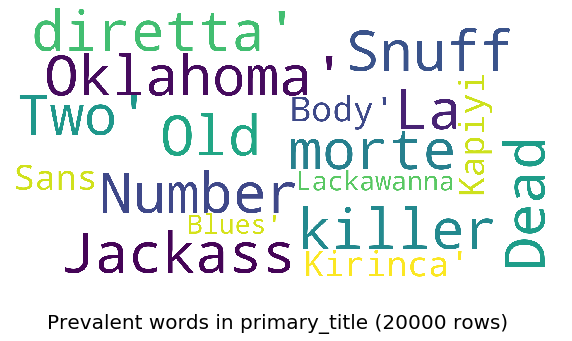

In [18]:
show_wordcloud('primary_title', train_df)

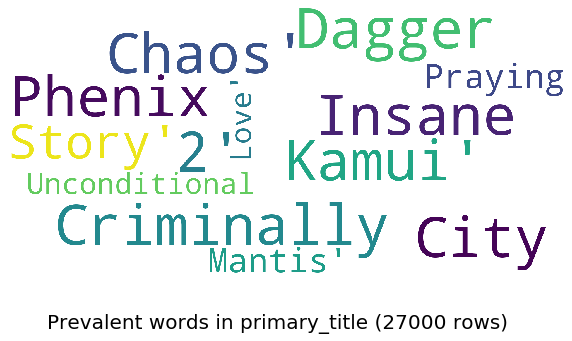

In [19]:
show_wordcloud('primary_title', test_df)

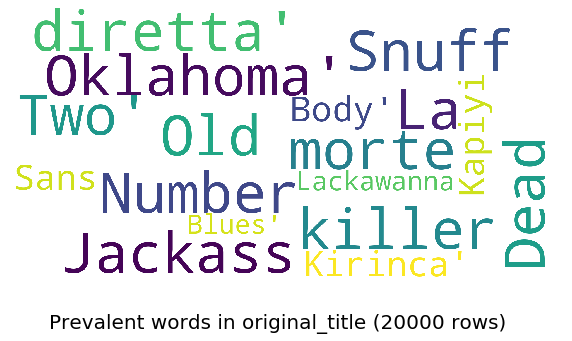

In [20]:
show_wordcloud('original_title', train_df)

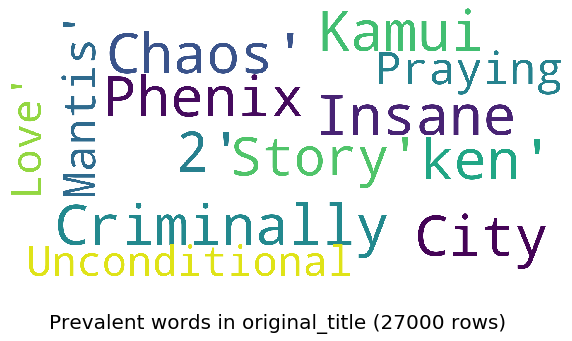

In [21]:
show_wordcloud('original_title', test_df)

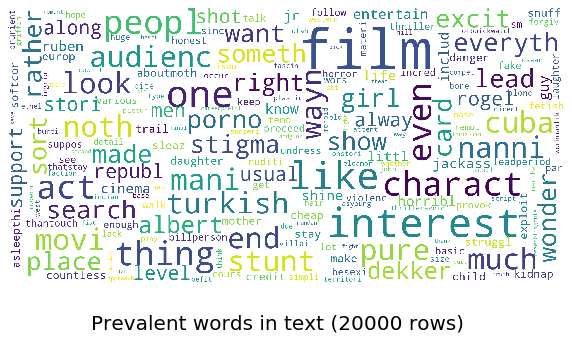

In [22]:
show_wordcloud('text', train_df)

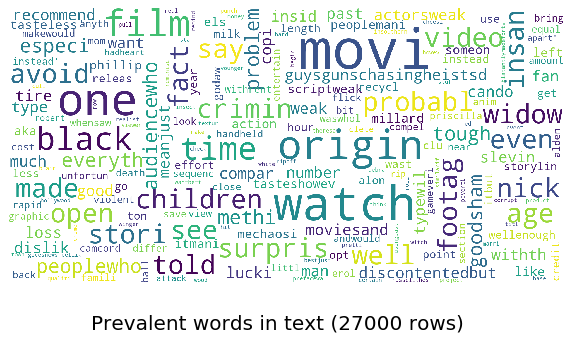

In [23]:
show_wordcloud('text', test_df)

D:\utils\Continuum\miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\utils\Continuum\miniconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


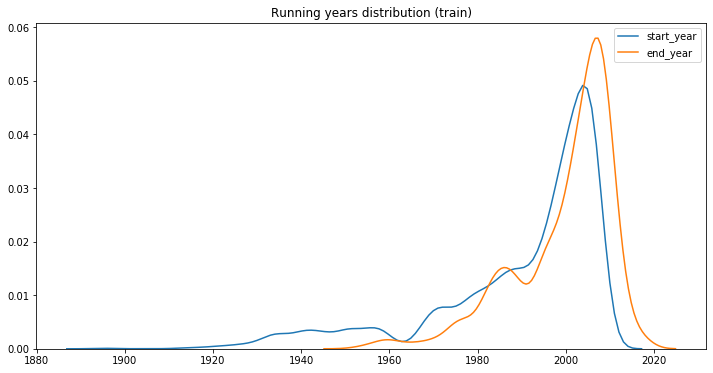

In [24]:
plot_features_distribution(['start_year', 'end_year'], 'Running years distribution (train)', train_df)

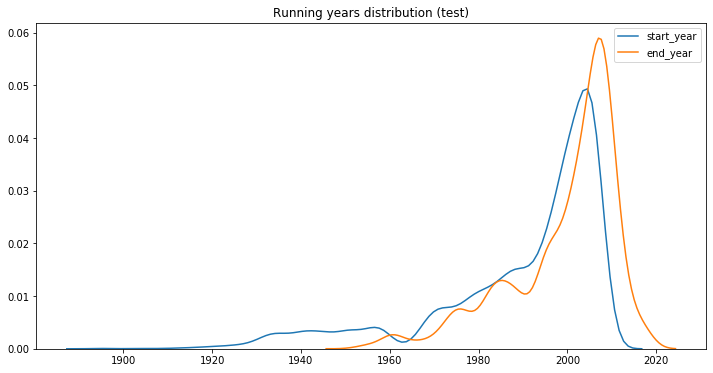

In [25]:
plot_features_distribution(['start_year', 'end_year'], 'Running years distribution (test)', test_df)

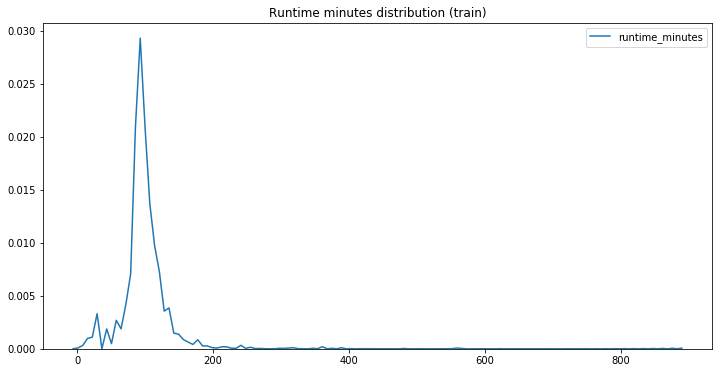

In [26]:
plot_features_distribution(['runtime_minutes'], 'Runtime minutes distribution (train)', test_df)

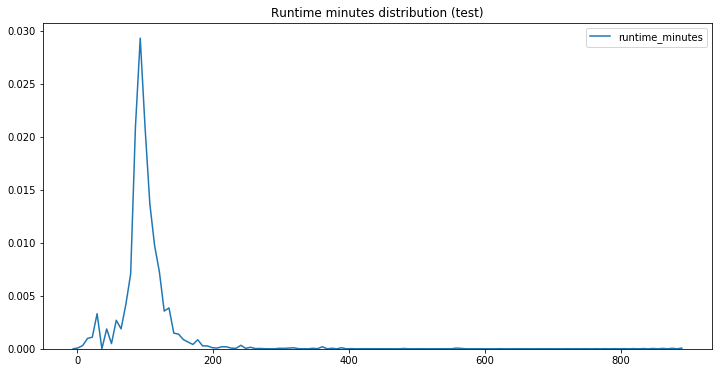

In [27]:
plot_features_distribution(['runtime_minutes'], 'Runtime minutes distribution (test)', test_df)

In [28]:
print(f"Movies in train: {train_df.title_id.nunique()} and test: {test_df.title_id.nunique()}")
l1 = set(train_df.title_id.unique())
l2 = set(test_df.title_id.unique())
card_int = len(l1.intersection(l2))
print(f"Common movies in train & test: {card_int}")

Movies in train: 5286 and test: 5839
Common movies in train & test: 4484


Only one movie is common between `train` and `test`.

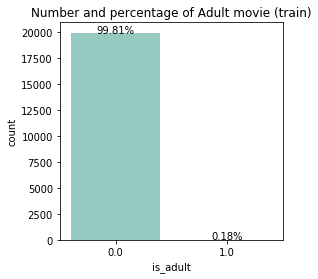

In [29]:
plot_count('is_adult', 'Adult movie (train)', train_df, size=1)

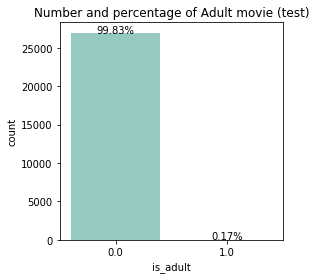

In [30]:
plot_count('is_adult', 'Adult movie (test)', test_df, size=1)

# Baseline model

We will create a very simple model using only review text data, based on Count vectorizer, without text data pre-processing.

In [31]:
def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
#     cv = CountVectorizer(max_features=max_features,
#                              ngram_range=(1, 1),
#                              stop_words='english')
# analyzer='char_wb', ngram_range=(2, 2)
#     cv = CountVectorizer(max_features=max_features, min_df=5, max_df=0.7, ngram_range=(1, 1),
#                              stop_words='english')
#     cv = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.7, ngram_range=(1, 1),
#                              stop_words='english')
#     cv = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.7, ngram_range=(1, 2), sublinear_tf=True,
#                              stop_words='english')
    cv = TfidfVectorizer(max_features=max_features, max_df=0.7, ngram_range=(1, 2), sublinear_tf=True,
                             stop_words='english')
#     cv = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.7, ngram_range=(1, 2),
#                              stop_words='english')
    X_feature = cv.fit_transform(df[feature])
#     print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    print('Tfidf Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature


In [32]:
data = pd.concat([train_df, test_df])

D:\utils\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [33]:
data.shape

(47000, 12)

In [57]:
X_feature = count_vect_feature('text', data, max_features=100000) # 100000

Tfidf Vectorizer `text` completed in 49.51 sec.


In [58]:
X = X_feature[0:train_df.shape[0]]
X_test = X_feature[train_df.shape[0]:]
y = train_df.polarity.values
print(f"X: {X.shape} test X: {X_test.shape} y: {y.shape}")
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 42) 
print(f"train X: {train_X.shape}, valid X: {valid_X.shape}, train y: {train_y.shape}, valid y: {valid_y.shape}")

X: (20000, 100000) test X: (27000, 100000) y: (20000,)
train X: (14000, 100000), valid X: (6000, 100000), train y: (14000,), valid y: (6000,)


In [59]:
# a = train_X.toarray()

In [62]:
# a
print(train_X.shape[1])

100000


Run DNN:

In [66]:
model_DNN = Sequential()
node = 512 # number of nodes

model_DNN.add(Dense(node,input_dim=train_X.shape[1],activation='relu',kernel_initializer='he_normal',
                    kernel_regularizer=rg.l2(0.0001)))
model_DNN.add(BatchNormalization())
model_DNN.add(Dropout(0.15))

model_DNN.add(Dense(node,input_dim=node,activation='relu',kernel_initializer='he_normal',
                    kernel_regularizer=rg.l2(0.0001)))
model_DNN.add(Dropout(0.25))
model_DNN.add(Dense(node,input_dim=node,activation='relu',kernel_initializer='he_normal',
                    kernel_regularizer=rg.l2(0.0001)))
model_DNN.add(Dropout(0.35))
model_DNN.add(Dense(node,input_dim=node,activation='relu',kernel_initializer='he_normal',
                    kernel_regularizer=rg.l2(0.0001)))
model_DNN.add(Dropout(0.45))
model_DNN.add(Dense(node,input_dim=node,activation='relu',kernel_initializer='he_normal',
                    kernel_regularizer=rg.l2(0.0001)))
model_DNN.add(BatchNormalization())
model_DNN.add(Dropout(0.5))


model_DNN.add(Flatten())
model_DNN.add(Dense(node, kernel_initializer='he_normal', activation='relu'))
model_DNN.add(BatchNormalization())
model_DNN.add(Dropout(0.4))

    
model_DNN.add(Dense(10, activation='softmax'))    
model_DNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_DNN.fit(train_X, train_y, validation_data=(valid_X, valid_y), epochs=5, batch_size=512, verbose=2)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 14000 samples, validate on 6000 samples
Epoch 1/5
14000/14000 - 86s - loss: 2.7190 - acc: 0.4116 - val_loss: 1.9675 - val_acc: 0.7982
Epoch 2/5
14000/14000 - 87s - loss: 0.9318 - acc: 0.9209 - val_loss: 1.2708 - val_acc: 0.8017
Epoch 3/5
14000/14000 - 74s - loss: 0.6115 - acc: 0.9907 - val_loss: 1.5488 - val_acc: 0.5038
Epoch 4/5
14000/14000 - 82s - loss: 0.5800 - acc: 0.9986 - val_loss: 2.0070 - val_acc: 0.4930
Epoch 5/5
14000/14000 - 79s - loss: 0.5661 - acc: 0.9992 - val_loss: 2.2041 - val_acc: 0.4928


In [67]:
pre_pred = model_DNN.predict(valid_X)

In [68]:
pre_pred.shape

(6000, 10)

In [69]:
print(np.argmax(pre_pred, axis=1))

[0 0 0 ... 0 0 0]


In [70]:
predicted = np.argmax(pre_pred, axis=1)

In [71]:
print(predicted)

[0 0 0 ... 0 0 0]


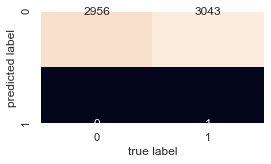

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      2956
           1       1.00      0.00      0.00      3044

    accuracy                           0.49      6000
   macro avg       0.75      0.50      0.33      6000
weighted avg       0.75      0.49      0.33      6000

ROC-AUC: 0.7463743957326221


In [75]:
show_confusion_matrix(valid_y, predicted, size=1)
print(classification_report(valid_y, predicted))
print(f"ROC-AUC: {roc_auc_score(predicted, valid_y)}")

# print(len(valid_y))
# print(predicted)

# Submission

Let's predict the polarity for the test set.

In [73]:
pre_pred_test = model_DNN.predict(X_test)
predict_test = np.argmax(pre_pred_test, axis=1)

In [74]:
submission = pd.read_csv('./input/sampleSubmission.csv')
submission['polarity'] = predict_test
submission.to_csv('./input/submission.csv', index=False)

# Further improvements

* Pre-process the text data: clean contraction, clean special characters, eliminate stop words, use lematization or stemming;
* Use different text vectorizing options;
* Use other models;
* Add additional features (categorical or numerical);
* Perform model tuning
